<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Explainability-with-Amazon-SageMaker-Debugger" data-toc-modified-id="Explainability-with-Amazon-SageMaker-Debugger-1">Explainability with Amazon SageMaker Debugger</a></span><ul class="toc-item"><li><span><a href="#Introduction-" data-toc-modified-id="Introduction--1.1">Introduction <a id="intro"></a></a></span><ul class="toc-item"><li><span><a href="#Saving-tensors" data-toc-modified-id="Saving-tensors-1.1.1">Saving model parameters</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.1.2">Analysis</a></span></li></ul></li><li><span><a href="#Section-1---Setup-" data-toc-modified-id="Section-1---Setup--1.2">Section 1 - Setup <a id="setup"></a></a></span><ul class="toc-item"><li><span><a href="#1.1-Import-necessary-libraries" data-toc-modified-id="1.1-Import-necessary-libraries-1.2.1">1.1 Import necessary libraries</a></span></li><li><span><a href="#1.2-AWS-region-and--IAM-Role" data-toc-modified-id="1.2-AWS-region-and--IAM-Role-1.2.2">1.2 AWS region and  IAM Role</a></span></li><li><span><a href="#1.3-S3-bucket-and-prefix-to-hold-training-data,-debugger-information-and-model-artifact" data-toc-modified-id="1.3-S3-bucket-and-prefix-to-hold-training-data,-debugger-information-and-model-artifact-1.2.3">1.3 S3 bucket and prefix to hold training data, debugger information and model artifact</a></span></li></ul></li><li><span><a href="#Section-2---Data-preparation-" data-toc-modified-id="Section-2---Data-preparation--1.3">Section 2 - Data preparation <a id="prep-data"></a></a></span></li><li><span><a href="#Section-3---Train-XGBoost-model-in-Amazon-SageMaker-with--debugger-enabled.-" data-toc-modified-id="Section-3---Train-XGBoost-model-in-Amazon-SageMaker-with--debugger-enabled.--1.4">Section 3 - Train XGBoost model in Amazon SageMaker with  debugger enabled. <a id="train"></a></a></span><ul class="toc-item"><li><span><a href="#3.1-Install-the-'smdebug'-open-source-library" data-toc-modified-id="3.1-Install-the-'smdebug'-open-source-library-1.4.1">3.1 Install the 'smdebug' open source library</a></span></li><li><span><a href="#3.2-Build-the-XGBoost-container" data-toc-modified-id="3.2-Build-the-XGBoost-container-1.4.2">3.2 Build the XGBoost container</a></span></li><li><span><a href="#3.3-Enabling-Debugger-in-Estimator-object" data-toc-modified-id="3.3-Enabling-Debugger-in-Estimator-object-1.4.3">3.3 Enabling Debugger in Estimator object</a></span><ul class="toc-item"><li><span><a href="#DebuggerHookConfig" data-toc-modified-id="DebuggerHookConfig-1.4.3.1">DebuggerHookConfig</a></span></li><li><span><a href="#Rules" data-toc-modified-id="Rules-1.4.3.2">Rules</a></span></li></ul></li><li><span><a href="#3.4-Result" data-toc-modified-id="3.4-Result-1.4.4">3.4 Result</a></span></li><li><span><a href="#3.5-Check-the-status-of-the-Rule-Evaluation-Job" data-toc-modified-id="3.5-Check-the-status-of-the-Rule-Evaluation-Job-1.4.5">3.5 Check the status of the Rule Evaluation Job</a></span></li></ul></li><li><span><a href="#Section-4---Analyze-debugger-output-" data-toc-modified-id="Section-4---Analyze-debugger-output--1.5">Section 4 - Analyze debugger output <a id="analyze-debugger-ouput"></a></a></span><ul class="toc-item"><li><span><a href="#Retrieving-and-Analyzing-tensors" data-toc-modified-id="Retrieving-and-Analyzing-tensors-1.5.1">Retrieving and Analyzing model parameters</a></span></li><li><span><a href="#Plot-Performance-metrics" data-toc-modified-id="Plot-Performance-metrics-1.5.2">Plot Performance metrics</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-1.5.3">Feature importance</a></span></li><li><span><a href="#SHAP" data-toc-modified-id="SHAP-1.5.4">SHAP</a></span></li><li><span><a href="#Global-explanations" data-toc-modified-id="Global-explanations-1.5.5">Global explanations</a></span></li><li><span><a href="#Local-explanations" data-toc-modified-id="Local-explanations-1.5.6">Local explanations</a></span><ul class="toc-item"><li><span><a href="#Force-plot" data-toc-modified-id="Force-plot-1.5.6.1">Force plot</a></span></li><li><span><a href="#Stacked-force-plot" data-toc-modified-id="Stacked-force-plot-1.5.6.2">Stacked force plot</a></span></li></ul></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-1.5.7">Outliers</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.6">Conclusion</a></span></li></ul></li></ul></div>

# Explainability with Amazon SageMaker Debugger
_**Explain a XGBoost model that predicts an individual's income**_

This notebook demonstrates how to use Amazon SageMaker Debugger to capture the feature importance and SHAP values for a XGBoost model.

*This notebook was created and tested on an ml.t2.medium notebook instance.*

## Introduction <a id='intro'></a>

Amazon SageMaker Debugger is the capability of Amazon SageMaker that allows debugging machine learning training. The capability helps you monitor the training jobs in near real time using rules and alert you once it has detected inconsistency in training. 

Using Amazon SageMaker Debugger is a two step process: Saving model parameters and Analysis.
Let's look at each one of them closely.

### Saving model parameters

In machine learning process, model parameters are updated every forward and backward pass and can describe the state of the training job at any particular instant in an ML lifecycle. Amazon SageMaker Debugger  allows you to capture the model parameters and save them for analysis. Although XGBoost is not a deep learning algorithm, Amazon SageMaker Debugger is highly customizable and can help you interpret results by saving insightful metrics. For example, performance metrics or the importance of features at different frequencies. Refer to [SageMaker Debugger  documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configuration.html) for details on how to save the metrics you want.  

The saved model parameters in this notebook include feature importance and SHAP values for all features in the dataset. The feature importance and SHAP values are what we will use to provide local and global explainability.


### Analysis

After the model parameters are saved, perform automatic analysis by running debugging ***Rules***.
On a very broad level, a rule is Python code used to detect certain conditions during training.
Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on.
Amazon SageMaker Debugger comes pre-packaged with certain rules that can be invoked on Amazon SageMaker. Users can also write their own rules using the Amazon SageMaker Debugger APIs. 
For more information about automatic analysis using a rule, see the [rules documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md).
 

## Section 1 - Setup <a id='setup'></a>

In this section, we will import the necessary libraries, setup variables and examine dataset used. that was used to train the XGBoost model to predict an individual's income.

Let's start by specifying:

* The AWS region used to host your model.
* The IAM role associated with this SageMaker notebook instance.
* The S3 bucket used to store the data used to train the model, save debugger information during training and the trained model artifact.

<font color='red'>**Important**</font>: To use the new Debugger features, you need to upgrade the SageMaker Python SDK and the SMDebug libary. In the following cell, change the third line to `install_needed=True` and run to upgrade the libraries.

In [ ]:
import sys
import IPython
install_needed = False  # Set to True to upgrade
if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U sagemaker
    !{sys.executable} -m pip install -U smdebug
    IPython.Application.instance().kernel.do_shutdown(True)

### 1.1 Import necessary libraries

In [ ]:
import boto3
import sagemaker
import os
import pandas as pd

from sagemaker import get_execution_role

### 1.2 AWS region and  IAM Role

In [ ]:
region = boto3.Session().region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

### 1.3 S3 bucket and prefix to hold training data, debugger information, and model artifact

In [ ]:
bucket = sagemaker.Session().default_bucket()
prefix = "DEMO-smdebug-xgboost-adult-income-prediction"

## Section 2 - Data preparation <a id='prep-data'></a>

We'll be using the [Adult Census dataset](https://archive.ics.uci.edu/ml/datasets/adult) for this exercise. 
This data was extracted from the [1994 Census bureau database](http://www.census.gov/en.html) by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics), with the task being to predict if an individual person makes over 50K a year. 

We'll be using the [SHAP](https://github.com/slundberg/shap) library to perform visual analysis. The library contains the dataset pre-loaded which we will utilize here. 

In [ ]:
!python -m pip install shap

In [ ]:
import shap

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
feature_names = list(X.columns)

In [ ]:
feature_names

In [ ]:
# create a train/test split
from sklearn.model_selection import train_test_split  # For splitting the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train_display = X_display.loc[X_train.index]

In [ ]:
train = pd.concat(
    [pd.Series(y_train, index=X_train.index, name="Income>50K", dtype=int), X_train], axis=1
)
test = pd.concat(
    [pd.Series(y_test, index=X_test.index, name="Income>50K", dtype=int), X_test], axis=1
)

# Use 'csv' format to store the data
# The first column is expected to be the output column
train.to_csv("train.csv", index=False, header=False)
test.to_csv("validation.csv", index=False, header=False)

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "data/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "data/validation.csv")
).upload_file("validation.csv")

## Section 3 - Train XGBoost model in Amazon SageMaker with  debugger enabled. <a id='train'></a>

Now train an XGBoost model with Amazon SageMaker Debugger enabled and monitor the training jobs. This is done using the Amazon SageMaker Estimator API. While the training job is running, use Amazon SageMaker Debugger API to access saved model parameters in real time and visualize them. You can rely on Amazon SageMaker Debugger to take care of downloading a fresh set of model parameters every time you query for them.

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version 0.90-2 or later. If you want to use XGBoost with Amazon SageMaker Debugger, you have to specify `repo_version='0.90-2'` in the `get_image_uri` function.

### 3.2 Build the XGBoost container

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version 0.90-2 or later.

In [ ]:
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

In [ ]:
base_job_name = "demo-smdebug-xgboost-adult-income-prediction-classification"
bucket_path = "s3://{}".format(bucket)

hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "silent": "0",
    "objective": "binary:logistic",
    "num_round": "51",
}
save_interval = 5

### 3.3 Enabling Debugger in Estimator object


#### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: Points to an S3 bucket where you intend to store model parameters. Amount of data saved depends on multiple factors, major ones are training job, data set, model, frequency of saving model parameters. This S3 bucket should be in your AWS account so that you have full access to control over the stored data. **Note**: The S3 bucket should be originally created in the same Region where your training job is running, otherwise you might run into problems with cross-Region access.

- `collection_configs`: It enumerates named collections of model parameters to save. Collections are a convenient way to organize relevant model parameters under same umbrella to make it easy to navigate them during analysis. In this particular example, you are interested in a single collection named metrics. You also configured Amazon SageMaker Debugger to save metrics every 10 iterations. See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.
  
#### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into Estimator object constructor.

- `rules`: This parameter will accept a list of rules you want to evaluate against training jobs.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use a Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the loss value in the `metrics` collection has not decreased for more than 10 steps.

In [ ]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

xgboost_estimator = Estimator(
    role=role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    image_uri=container,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(name="metrics", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": str(save_interval)}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="average_shap", parameters={"save_interval": str(save_interval)}),
        ],
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)

With the next step, start a training job by using the Estimator object you created above. This job is started in an asynchronous, non-blocking way. This means that control is passed back to the notebook and further commands can be run while the training job is progressing.

In [ ]:
from sagemaker.session import TrainingInput

train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation.csv"), content_type="csv"
)
xgboost_estimator.fit(
    {"train": train_input, "validation": validation_input},
    # This is a fire and forget event. By setting wait=False, you submit the job to run in the background.
    # Amazon SageMaker starts one training job and release control to next cells in the notebook.
    # Follow this notebook to see status of the training job.
    wait=False,
)

### 3.4 Result

As a result of the above command, Amazon SageMaker starts **one training job and one rule job** for you. The first one is the job that produces the model parameters to be analyzed. The second one analyzes the model parameters to check if `train-error` and `validation-error` are not decreasing at any point during training.

Check the status of the training job below.
After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.  

The cell below will block till the training job is complete.

In [ ]:
import time

for _ in range(36):
    job_name = xgboost_estimator.latest_training_job.name
    client = xgboost_estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = xgboost_estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )

    if training_job_status in ["Completed", "Failed"]:
        break

    time.sleep(10)

### 3.5 Check the status of the Rule Evaluation Job

To get the rule evaluation job that Amazon SageMaker started for you, run the command below. The results show you the `RuleConfigurationName`, `RuleEvaluationJobArn`, `RuleEvaluationStatus`, `StatusDetails`, and `RuleEvaluationJobArn`.
If the model parameters meet a rule evaluation condition, the rule execution job throws a client error with `RuleEvaluationConditionMet`.

The logs of the rule evaluation job are available in the Cloudwatch Logstream `/aws/sagemaker/ProcessingJobs` with `RuleEvaluationJobArn`.

You can see that once the rule execution job starts, it identifies the loss not decreasing situation in the training job, it raises the `RuleEvaluationConditionMet` exception, and it ends the job.

In [ ]:
xgboost_estimator.latest_training_job.rule_job_summary()

## Section 4 - Analyze debugger output <a id='analyze-debugger-ouput'></a>

Now that you've trained the system, analyze the data.  Here, you focus on after-the-fact analysis.

You import a basic analysis library, which defines the concept of trial, which represents a single training run.

### Retrieving and Analyzing tensors

Before getting to analysis, here are some notes on concepts being used in Amazon SageMaker Debugger that help with analysis.
- ***Trial*** - Object that is a centerpiece of the SageMaker Debugger API when it comes to getting access to model parameters. It is a top level abstract that represents a single run of a training job. All model parameters emitted by a training job are associated with its trial.
- ***Tensor*** - Object that represents model parameters, such as weights, gradients, accuracy, and loss, that are saved during training job.

For more details on aforementioned concepts as well as on SageMaker Debugger API in general (including examples) see [SageMaker Debugger Analysis API](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md) documentation.

In the following code cell, use a ***Trial*** to access model parameters. You can do that by inspecting currently running training job and extract necessary parameters from its debug configuration to instruct SageMaker Debugger where the data you are looking for is located. Keep in mind the following:
- model parameters are being stored in your own S3 bucket to which you can navigate and manually inspect its content if desired.
- You might notice a slight delay before trial object is created. This is normal as SageMaker Debugger monitors the corresponding bucket and waits until model parameters to appear. The delay is introduced by less than instantaneous upload of model parameters from a training container to your S3 bucket. 

In [ ]:
from smdebug.trials import create_trial

s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

You can list all model parameters that you want to analyze. Each one of these names is the name of a model parameter. The name is a combination of the feature name, which in these cases, is auto-assigned by XGBoost, and whether it's an evaluation metric, feature importance, or SHAP value.

In [ ]:
trial.tensor_names()

For each model parameter, we can get the values at all saved steps. 

In [ ]:
trial.tensor("average_shap/f1").values()

### Plot Performance metrics

You can also create a simple function that visualizes the training and validation errors as the training progresses.
The error should get smaller over time, as the system converges to a good solution.

In [153]:
from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

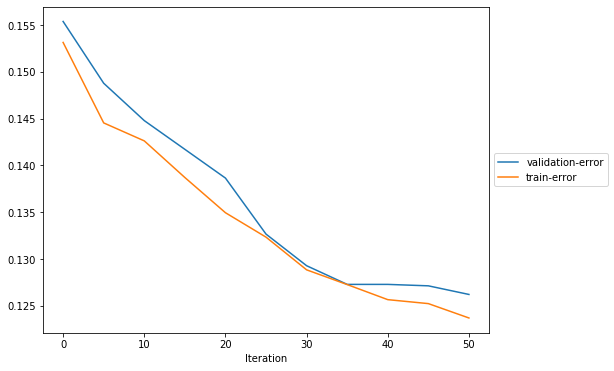

In [154]:
plot_collection(trial, "metrics")

### Feature importance

You can also visualize the feature priorities as determined by
[xgboost.get_score()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
If you instructed Estimator to log the `feature_importance` collection, all importance types supported by `xgboost.get_score()` will be available in the collection.

In [155]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

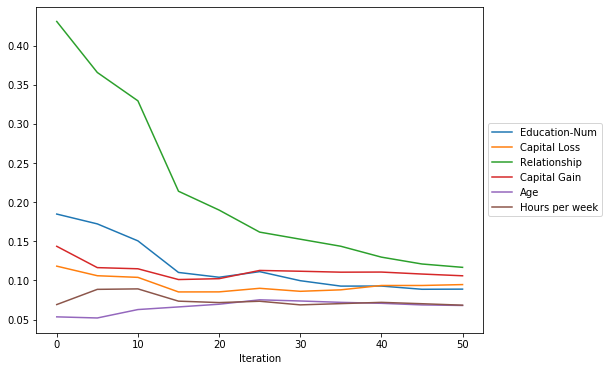

In [156]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.
You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

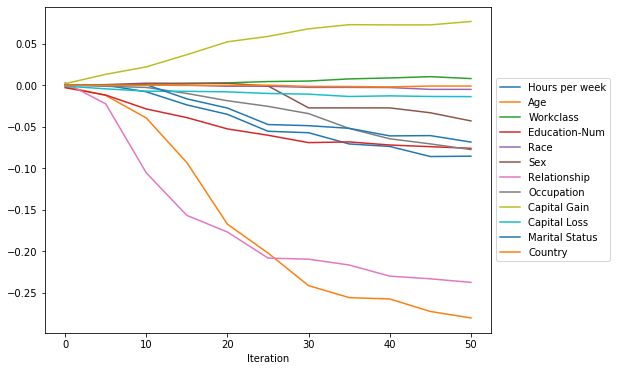

In [157]:
plot_collection(trial, "average_shap")

### Global explanations

Global explanatory methods allow understanding the model and its feature contributions in aggregate over multiple datapoints. Here we show an aggregate bar plot that plots the mean absolute SHAP value for each feature. 

Specifically, the below plot indicates that the value of relationship (Wife=5, Husband=4, Own-child=3, Other-relative=2, Unmarried=1, Not-in-family=0) plays the most important role in predicting the income probability being higher than 50K.

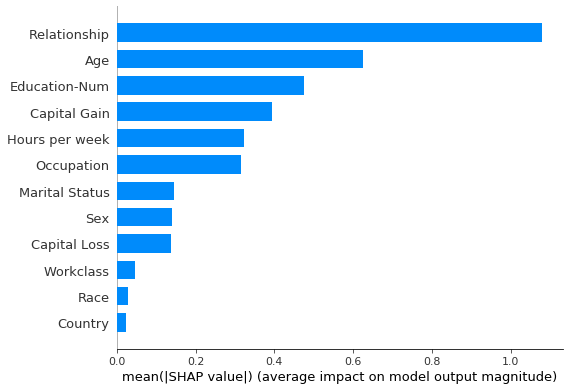

In [150]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [68]:
shap_base_value

-1.3971375

The detailed summary plot below can provide more context over the above bar chart. It tells which features are most important and, in addition, their range of effects over the dataset. The color allows us to match how changes in the value of a feature effect the change in prediction. 

The 'red' indicates higher value of the feature and 'blue' indicates lower (normalized over the features). This allows conclusions such as 'increase in age leads to higher log odds for prediction, eventually leading to `True` predictions more often. 

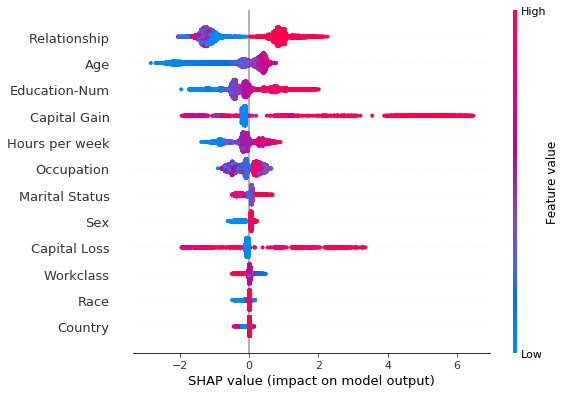

In [36]:
shap.summary_plot(shap_no_base, X_train)

### Local explanations

Local explainability aims to explain model behavior for a fixed input point. This can be used for either auditing models before deployment or to provide explanations for specific inference predictions. 

In [37]:
shap.initjs()

#### Force plot

A force plot explanation shows how features are contributing to push the model output from the base value (the average model output over the dataset) to the model output. Features pushing the prediction higher are shown in **red**, those pushing the prediction lower are in **blue**.

Plot below indicates that for this particular data point the prediction probability (0.48) is higher than the average (~0.2) primarily because this person is in a relationship (`Relationship = Wife`), and to smaller degree because of the higher-than-average age. Similarly the model reduces the probability due specific `Sex` and `Race` values indicating existence of bias in model behavior (possibly due to bias in the data). 

In [158]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    X_train_display.iloc[100, :],
    link="logit",
    matplotlib=False,
)

#### Stacked force plot

SHAP allows stacking multiple force-plots after rotating 90 degress to understand the explanations for multiple datapoints. If Javascript is enabled, then in the notebook this plot is interactive, allowing understanding the change in output for each feature independently. This stacking of force plots provides a balance between local and global explainability.

In [39]:
import numpy as np

N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [40]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    X_train_display.iloc[sampled_indices, :],
    link="logit",
)

### Outliers

Outliers are extreme values that deviate from other observations on data. It's useful to understand the influence of various features for outlier predictions to determine if it's a novelty, an experimental error, or a shortcoming in the model.

Here we show force plot for prediction outliers that are on either side of the baseline value.

In [160]:
# top outliers
from scipy import stats

N_OUTLIERS = 3  # number of outliers on each side of the tail

shap_sum = np.sum(shap_no_base, axis=1)
z_scores = stats.zscore(shap_sum)
outlier_indices = (np.argpartition(z_scores, -N_OUTLIERS)[-N_OUTLIERS:]).tolist()
outlier_indices += (np.argpartition(z_scores, N_OUTLIERS)[:N_OUTLIERS]).tolist()

In [161]:
for fig_index, outlier_index in enumerate(outlier_indices, start=1):
    shap.force_plot(
        shap_base_value,
        shap_no_base[outlier_index, :],
        X_train_display.iloc[outlier_index, :],
        matplotlib=False,
        link="logit",
    )

## Conclusion

This notebook discussed the importance of explainability for improved ML
adoption and. We introduced the Amazon SageMaker Debugger capability with built-in
model parameter collections to enable model explainability.
The notebook walked you through training an ML model for a financial services use case
of individual income prediction. We further analyzed the global and local
explanations of the model by visualizing the captured model parameters.